In [ ]:
# Import Libraries
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import jaccard_score
from albumentations.pytorch import ToTensorV2

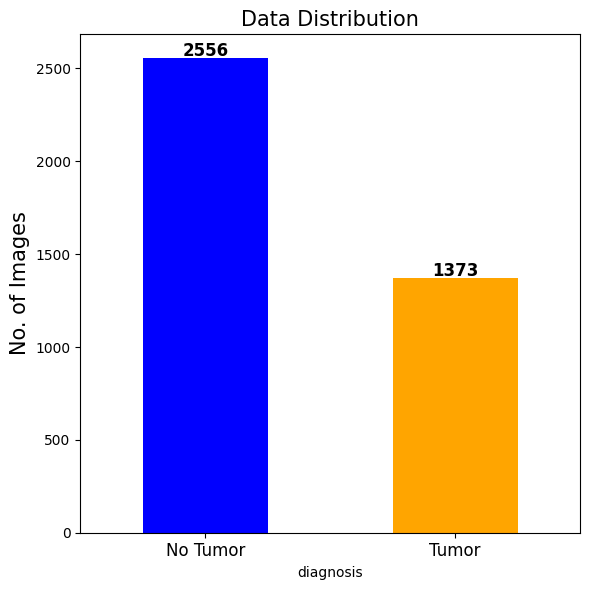

In [ ]:
ROOT_PATH = 'kaggle_3m'

# Find all mask files in subdirectories
mask_files = glob.glob(ROOT_PATH + '/**/*_mask.tif', recursive=True)

# Generate image paths
image_files = [file.replace('_mask', '') for file in mask_files]

# Diagnosis function
def diagnosis(mask_path):
    img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return 1 if np.max(img) > 0 else 0

# Create DataFrame
files_df = pd.DataFrame({
    "image_path": image_files,
    "mask_path": mask_files,
    "diagnosis": [diagnosis(x) for x in mask_files]
})

# Plotting
ax = files_df['diagnosis'].value_counts().plot(kind='bar', figsize=(6,6), color=['blue', 'orange'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)

# Add count annotations
for i, rows in enumerate(files_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows + 12), ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [4]:
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


In [ ]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Affine(translate_percent=0.1, scale=(0.9, 1.1), rotate=(-15, 15), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


val_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.3),  # Light flip
    A.RandomBrightnessContrast(p=0.1),  # Light color jitter
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [ ]:
from torch.utils.data import DataLoader
from src.dataset_format import TCGADataset

# Create datasets
train_dataset = TCGADataset(train_df, transform=train_transform)
val_dataset   = TCGADataset(val_df, transform=val_transform)
test_dataset  = TCGADataset(test_df, transform=val_transform)

# Create datalo
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
from src.models.SharpUNET import SharpUNetResNet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = SharpUNetResNet50(n_classes=1).to(device)

# Print model architecture
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s] 


SharpUNetResNet50(
  (encoder): ResNet50Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)

In [22]:
# Create dummy input (batch size = 1, 3 channels, 256x256 image)
dummy_input = torch.randn(1, 3, 256, 256).to(device)

# Forward pass
output = model(dummy_input)

# Print output shape
print("Output shape:", output.shape)  # Expected: torch.Size([1, 1, 256, 256])

Output shape: torch.Size([1, 1, 256, 256])


In [ ]:
decoder_params = []
for name, param in model.named_parameters():
    if not name.startswith('encoder.'):  
        decoder_params.append(param)

optimizer = torch.optim.Adam(decoder_params, lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss()
epochs = 20

In [25]:
import time
def train_resunet_resnet50(epochs, model, train_loader, val_loader, optimizer, loss_fn, device):
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model_wts = None

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    model.to(device)

    total_start_time = time.time()

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        model.train()
        running_train_loss = 0.0

        for img, mask in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training"):
            img = img.to(device)
            mask = mask.to(device).float() / 255.0

            optimizer.zero_grad()
            predictions = model(img)
            loss = loss_fn(predictions, mask)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * img.size(0)

        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for img, mask in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} - Validation", leave=False):
                img = img.to(device)
                mask = mask.to(device).float() / 255.0

                predictions = model(img)
                loss = loss_fn(predictions, mask)

                running_val_loss += loss.item() * img.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        val_loss = running_val_loss / len(val_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()

        scheduler.step()

        epoch_end_time = time.time()
        print(f"Epoch {epoch:02d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_end_time - epoch_start_time:.2f}s")

    total_time = time.time() - total_start_time
    print(f"\n✅ Total Training Time: {total_time // 60:.0f}m {total_time % 60:.0f}s")

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return history


In [26]:
history = train_resunet_resnet50(
    epochs=epochs,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)

Epoch 1/20 - Training: 100%|██████████| 752/752 [03:03<00:00,  4.09it/s]


Epoch 01/20 | Train Loss: 0.1687 | Val Loss: 0.0773 | Time: 195.03s


Epoch 2/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.11it/s]


Epoch 02/20 | Train Loss: 0.0522 | Val Loss: 0.0355 | Time: 194.43s


Epoch 3/20 - Training: 100%|██████████| 752/752 [03:03<00:00,  4.10it/s]


Epoch 03/20 | Train Loss: 0.0293 | Val Loss: 0.0271 | Time: 194.74s


Epoch 4/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.12it/s]


Epoch 04/20 | Train Loss: 0.0212 | Val Loss: 0.0332 | Time: 193.82s


Epoch 5/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.12it/s]


Epoch 05/20 | Train Loss: 0.0169 | Val Loss: 0.0161 | Time: 193.73s


Epoch 6/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.11it/s]


Epoch 06/20 | Train Loss: 0.0144 | Val Loss: 0.0161 | Time: 194.07s


Epoch 7/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.12it/s]


Epoch 07/20 | Train Loss: 0.0135 | Val Loss: 0.0147 | Time: 193.65s


Epoch 8/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.12it/s]


Epoch 08/20 | Train Loss: 0.0122 | Val Loss: 0.0126 | Time: 193.72s


Epoch 9/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.12it/s]


Epoch 09/20 | Train Loss: 0.0115 | Val Loss: 0.0113 | Time: 194.03s


Epoch 10/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.12it/s]


Epoch 10/20 | Train Loss: 0.0109 | Val Loss: 0.0123 | Time: 193.60s


Epoch 11/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.12it/s]


Epoch 11/20 | Train Loss: 0.0095 | Val Loss: 0.0106 | Time: 193.67s


Epoch 12/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.13it/s]


Epoch 12/20 | Train Loss: 0.0098 | Val Loss: 0.0115 | Time: 193.58s


Epoch 13/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.13it/s]


Epoch 13/20 | Train Loss: 0.0091 | Val Loss: 0.0109 | Time: 193.24s


Epoch 14/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.13it/s]


Epoch 14/20 | Train Loss: 0.0088 | Val Loss: 0.0112 | Time: 193.31s


Epoch 15/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.13it/s]


Epoch 15/20 | Train Loss: 0.0086 | Val Loss: 0.0107 | Time: 193.50s


Epoch 16/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.13it/s]


Epoch 16/20 | Train Loss: 0.0083 | Val Loss: 0.0131 | Time: 193.67s


Epoch 17/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.12it/s]


Epoch 17/20 | Train Loss: 0.0081 | Val Loss: 0.0128 | Time: 193.64s


Epoch 18/20 - Training: 100%|██████████| 752/752 [03:01<00:00,  4.13it/s]


Epoch 18/20 | Train Loss: 0.0082 | Val Loss: 0.0104 | Time: 193.20s


Epoch 19/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.12it/s]


Epoch 19/20 | Train Loss: 0.0081 | Val Loss: 0.0121 | Time: 193.80s


Epoch 20/20 - Training: 100%|██████████| 752/752 [03:02<00:00,  4.12it/s]
                                                                         

Epoch 20/20 | Train Loss: 0.0079 | Val Loss: 0.0116 | Time: 193.93s

✅ Total Training Time: 64m 36s


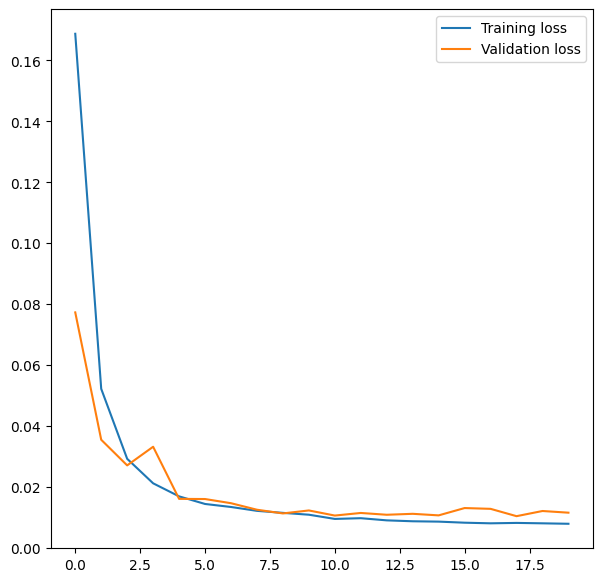

In [27]:
plt.figure(figsize=(7, 7))
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

def evaluate_model(model, test_loader, device):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # Metrics initialization
    total_tp = total_fp = total_fn = total_tn = 0

    with torch.no_grad():
        for img, mask in val_loader:
            img = img.to(device)
            mask = mask.to(device).float() / 255.0

            predictions = model(img)
            predictions = torch.sigmoid(predictions)

            preds_bin = predictions > 0.5
            all_preds.append(preds_bin.cpu().numpy())
            all_labels.append(mask.cpu().numpy())

            preds_flat = preds_bin.view(-1).cpu().numpy()
            mask_flat = mask.view(-1).cpu().numpy()

            tn, fp, fn, tp = confusion_matrix(mask_flat, preds_flat, labels=[0, 1]).ravel()

            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_tn += tn

    # Calculate metrics and store in a dict
    metrics = {
        'Accuracy': (total_tp + total_tn) / (total_tp + total_fp + total_fn + total_tn),
        'Precision': total_tp / (total_tp + total_fp) if (total_tp + total_fp) != 0 else 0,
        'Recall': total_tp / (total_tp + total_fn) if (total_tp + total_fn) != 0 else 0,
        'Specificity': total_tn / (total_tn + total_fp) if (total_tn + total_fp) != 0 else 0,
        'Dice Coefficient': 2 * total_tp / (2 * total_tp + total_fp + total_fn) if (2 * total_tp + total_fp + total_fn) != 0 else 0,
        'IoU': total_tp / (total_tp + total_fp + total_fn) if (total_tp + total_fp + total_fn) != 0 else 0
    }

    # Optional: print if you still want logs
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return all_preds, all_labels, metrics

In [ ]:
def plot_random_predictions_resnet18(model, test_loader, device, num_images=5):
    model.eval()
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

    for i in range(num_images):
        # Randomly sample a dataset entry
        img, mask = val_loader.dataset[np.random.randint(0, len(val_loader.dataset))]

        img = img.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(img)
            prediction = torch.sigmoid(prediction)

        # Convert to numpy arrays for plotting
        img_np = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        img_np = (img_np * 0.5 + 0.5).clip(0, 1)  # Unnormalize if you used normalization
        mask_np = mask.squeeze().cpu().numpy()
        pred_np = (prediction > 0.5).squeeze().cpu().numpy()

        # Plot Ground Truth
        axs[i, 0].imshow(img_np)
        axs[i, 0].imshow(mask_np, alpha=0.4, cmap='Greens')
        axs[i, 0].set_title("Ground Truth Mask")
        axs[i, 0].axis('off')

        # Plot Prediction
        axs[i, 1].imshow(img_np)
        axs[i, 1].imshow(pred_np, alpha=0.4, cmap='Reds')
        axs[i, 1].set_title("Predicted Mask")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
all_preds, all_labels, metrics = evaluate_model(model, test_loader, device)

Accuracy: 0.9961
Precision: 0.7781
Recall: 0.8912
Specificity: 0.9972
Dice Coefficient: 0.8308
IoU: 0.7106


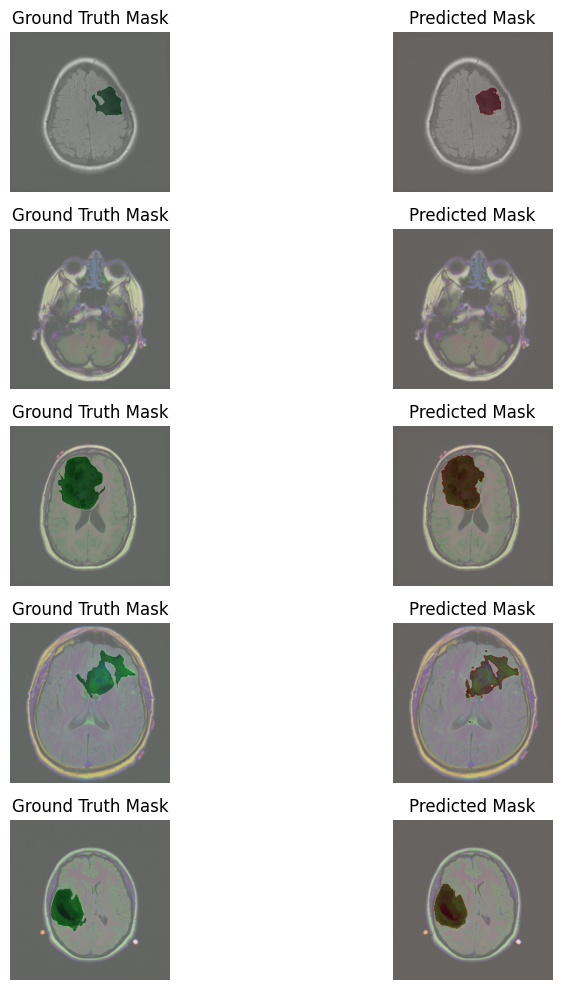

In [ ]:
plot_random_predictions_resnet18(model, test_loader, device, num_images=5)

In [32]:
torch.save(model.state_dict(), "SharpUNet_ResNet50.pth")